In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import numpy as np

In [2]:
data = pd.read_parquet('./input/creditos_hist.parquet')

In [3]:
# Eliminamos las situaciones 0, que indican que el crédito ya fue pagado
data = data.loc[data['situacion'] != 0]
data = data.drop('denominacion', axis = 1)

In [4]:
np.random.seed(42)
cuits = data['identificacion'].unique()
moneda = np.random.binomial(1, 0.01, len(cuits))
cuits_aleatorios = cuits[moneda == 1]

In [5]:
data = data.loc[data['identificacion'].isin(cuits_aleatorios)]

In [6]:
arca = pd.read_parquet('./input/constancia_inscripcion.parquet')

In [7]:
arca = arca.drop(['provincia', 'direccion', 'localidad', 'razonSocial'], axis = 1)

In [8]:
data = data.merge(arca, on = 'identificacion', how= 'left')

In [9]:
data = data[data['codPostal'].notna()]

# Variables de interés
Creamos nuevas variables que creemos que pueden ser útiles para predecir el default

In [10]:
# Una variable que puede ser de interés es cuantos créditos tiene una empresa en un momento dado del tiempo
counts = data.groupby(['identificacion', 'periodo']).size().reset_index(name='n_creditos')

# También nos interesa cuanta plata debe una empresa en cada momento dado
sums = data.groupby(['identificacion', 'periodo'], as_index=True)['monto'].sum().reset_index(name='sum_montos')

# La literatura indica que también importa la duración de la relación empresa-banco, por lo que contamos la cantidad 
# de periodos que aparece cada par: empresa-banco
period_counts = data.groupby(['identificacion', 'entidad']).size().reset_index(name='n_periodos')

# Definimos como default cuando el crédito se encuentra en situación 4 o 5, por lo que creamos la dummy de default
# Esta es nuestra variable dependiente
data['default'] = (data['situacion'] > 4).astype(int)

In [11]:
# Agregamos las nuevas variables al dataframe
data = data.merge(counts, on=['identificacion', 'periodo'], how='left')
data = data.merge(sums, on=['identificacion', 'periodo'], how='left')
data = data.merge(period_counts, on=['identificacion', 'entidad'], how='left')

del sums, counts, period_counts

In [12]:
# Por último, la literatura también resalta que la intensidad de la relación empresa-banco es relevante
# Usamos como proxy para la intensidad la proporción del monto adeudado con un banco sobre el total adeudado
data['monto_relativo'] = data['monto'] / data['sum_montos']

In [13]:
# Ponemos bien el tipo de dato para las columnas categóricas, así el get_dummies funciona bien
data['identificacion'] = data['identificacion'].astype('category')
data['entidad'] = data['entidad'].astype('category')
data['situacion'] = data['situacion'].astype('category')
data['default'] = data['default'].astype('category')
data['periodo'] = data['periodo'].astype('category')
data['codPostal'] = data['codPostal'].astype('category')
data['mesCierre'] = data['mesCierre'].astype('category')

In [14]:
boolean_columns = data.select_dtypes(include='object').columns
columnas = ['entidad', 'monto', 'n_creditos', 'sum_montos', 'n_periodos', 'monto_relativo', 'periodo']
columnas.extend(arca.columns)

In [15]:
columns_to_encode = [col for col in columnas if col not in boolean_columns]
X_encoded = pd.get_dummies(data[columns_to_encode], drop_first=True)
X = pd.concat([X_encoded, data[boolean_columns]], axis=1)
Y = data['default']

del columns_to_encode, X_encoded

In [16]:
sc = StandardScaler()
X = pd.DataFrame(sc.fit_transform(X), columns= X.columns)

In [17]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

También se puede hacer con neg_mean_squared_error, accuracy, f1_macro, f1_samples, average_precision, etc

In [18]:
model = LogisticRegressionCV(
    Cs=10, cv=5, penalty='l1', solver='saga', scoring='accuracy', n_jobs=-1, tol = 1e-3, max_iter=1000, random_state= 42, fit_intercept= True
)
model.fit(X_train, Y_train)

LogisticRegressionCV(cv=5, max_iter=1000, n_jobs=-1, penalty='l1',
                     random_state=42, scoring='accuracy', solver='saga',
                     tol=0.001)

In [19]:
best_C = model.C_
print(f"El mejor valor de C es: {best_C}")

El mejor valor de C es: [0.35938137]


In [20]:
y_pred = model.predict(X_test)
cm = confusion_matrix(Y_test, y_pred)
print(cm)

[[21944    24]
 [   49   148]]


In [21]:
precision = precision_score(Y_test, y_pred)
recall = recall_score(Y_test, y_pred)
f1 = f1_score(Y_test, y_pred)
accuracy = accuracy_score(Y_test, y_pred)

print(f'La precisión es: {precision}')
print(f'El recall es: {recall}')
print(f'El f1 es: {f1}')
print(f'El accuracy es: {accuracy}')

La precisión es: 0.8604651162790697
El recall es: 0.751269035532995
El f1 es: 0.8021680216802168
El accuracy es: 0.9967065192871645


Si predecimos siempre negativo:
|       | PN    | PP    |
|-------|-------|-------|
| **TN** | 21968 | 0     |
| **TP** | 197  | 0     |

* La precision sería: 0/0
* El recall sería: 0
* El f1 sería: 0
* El accuracy sería: 0.99111121137

In [22]:
coeficientes = model.coef_[0]  # Coeficientes para la clase positiva
proporcion_ceros = (coeficientes == 0).sum() / len(coeficientes)
print(f"Proporción de coeficientes iguales a 0: {proporcion_ceros:.2%}")


Proporción de coeficientes iguales a 0: 94.06%


In [23]:
df_coeficientes = pd.DataFrame({
    'variable': X_train.columns,
    'coeficiente': model.coef_[0]
})
print(df_coeficientes)

                                               variable  coeficiente
0                                                 monto    -0.000013
1                                            n_creditos     0.014229
2                                            sum_montos     0.000000
3                                            n_periodos     0.103199
4                                        monto_relativo     0.075615
...                                                 ...          ...
4860    VENTA DE AUTOS, CAMIONETAS Y UTILITARIOS NUEVOS     0.000000
4861   VENTA DE AUTOS, CAMIONETAS Y UTILITARIOS, USADOS     0.000000
4862  VENTA DE MOTOCICLETAS Y DE SUS PARTES, PIEZAS ...    -0.000337
4863       VENTA DE VEHÍCULOS AUTOMOTORES NUEVOS N.C.P.     0.000000
4864       VENTA DE VEHÍCULOS AUTOMOTORES USADOS N.C.P.     0.000000

[4865 rows x 2 columns]


In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

scores_df = pd.DataFrame(model.scores_[1], columns=[f'C={c:.2e}' for c in model.Cs_])
scores_df = scores_df.melt(var_name='C', value_name='Score')

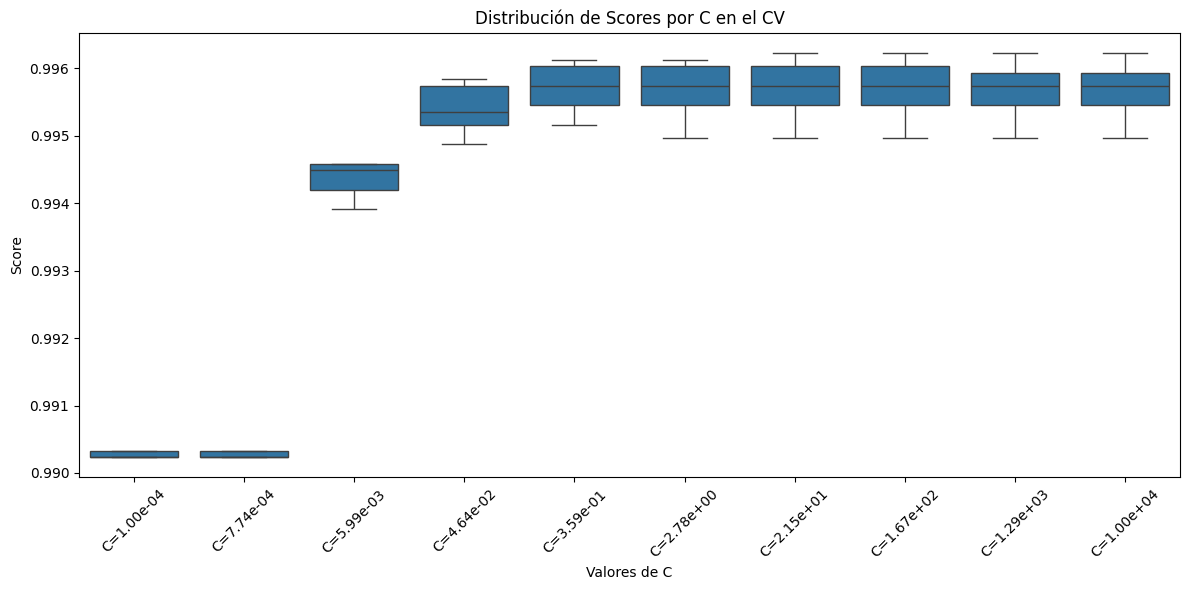

In [26]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=scores_df, x='C', y='Score')
plt.xticks(rotation=45) 
plt.title('Distribución de Scores por C en el CV')
plt.xlabel('Valores de C')
plt.ylabel('Score')
plt.tight_layout()
plt.show()